In [1]:
import torch #Torch is an open-source machine learning library,It provides a wide range of algorithms for deep learning
import torch.nn as nn #The nn package is used for building neural networks. nn.Module, nn.con2d, nn.linear
import torch.nn.functional as F #This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions.
from torch.utils.data import DataLoader #Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.
from torchvision import datasets, transforms, models # transforms is for imageTransformation #add models to the list
from torchvision.utils import make_grid
import os
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")





In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


In [3]:
root = '/home/amit/Documents/amitpython/DataSampleForExperiment1000/GRAPES/GRAPES'
##Load the Dataset

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)


#Create Loaders to make our dataset iterable
torch.manual_seed(77)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

class_names = train_data.classes

print(class_names)

print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the test loader'.format(len(test_loader)))

['Grape_Black_Measles', 'Grape_Black_Rot', 'Grape_Healthy', 'Grape_Isariopsis']
Training images available: 800
Testing images available:  200
There are 160 batches in the train loader
There are 40 batches in the test loader


Label: [1 3 0 1 3]
Class: Grape_Black_Rot Grape_Isariopsis Grape_Black_Measles Grape_Black_Rot Grape_Isariopsis


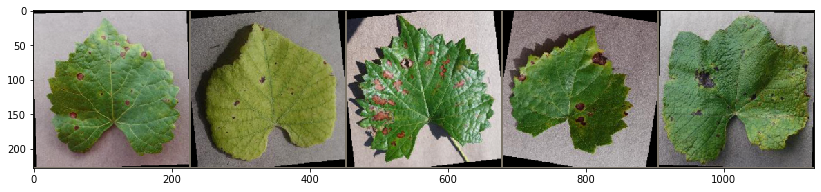

In [4]:
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=9)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 4)

    def forward(self, ImgObj):
        fm = F.relu(self.conv1(ImgObj))
        fm = F.max_pool2d(fm, 2, 2)
        fm = F.relu(self.conv2(fm))
        fm = F.max_pool2d(fm, 2, 2)
        fm = fm.view(-1, 54*54*16)
        fm = F.relu(self.fc1(fm))
        fm = F.relu(self.fc2(fm))
        fm = self.fc3(fm)
        return F.log_softmax(fm, dim=1)


In [6]:
#torch.manual_seed(101)
CNNmodel = CNN()
loss_fn = nn.CrossEntropyLoss()  #loss_fn
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=4, bias=True)
)

In [7]:
import time
start_time = time.time()

epochs = 8

train_losses_all = []
test_losses_all = []
train_correct_all = []  
test_correct_all = []   

for i in range(epochs):    #i is current epoch which is set to 0 at 1st
    train_correct = 0        
    test_correct = 0              
    total_correct = 0          
    iterations = 0
    loss_in_iter = 0.0     
    
    CNNmodel.train() 
    
    # Run the training batches    
    for x, (imgTensor, labels) in enumerate(train_loader): 
        
        # Apply the model          
        imgTensorOut = CNNmodel(imgTensor) 
        loss = loss_fn(imgTensorOut, labels) 
        loss_in_iter += loss.item()   
 
        #  let's calculate accuracy
        predicted_index = torch.max(imgTensorOut.data, 1)[1]  
        #This returns 2 vals,1st is _, max real value and 2nd i.e predicted which is index.we want index 
        #the second field i.e predicted of themaximum value , not the 1stone i.e _ which we ignored here.
        total_correct += (predicted_index == labels).sum().item() #batch_corr = correct
        
        
        
        train_correct += total_correct
        iterations += 1
        
        # Update parameters   
        optimizer.zero_grad()  #clear gradient buffer w <-- w- lr*gradient
        loss.backward()         # backpropgation
        optimizer.step()       # update weight

    
    train_losses_all.append(loss_in_iter/iterations)
  
    train_correct_all.append((100 * total_correct / len(train_data)))
  

    # Run the testing batches
    iterations = 0
    testing_loss = 0.0
    test_correct_in_test = 0
    with torch.no_grad():
        for b, (imgT, lbs) in enumerate(test_loader):  
        
            # Apply the model
            imgTensorOutTest = CNNmodel(imgT) 

            # Tally the number of correct predictions
            predicted_index = torch.max(imgTensorOutTest.data, 1)[1] 
            test_correct_in_test += (predicted_index == lbs).sum().item()  
            iterations += 1
            loss = loss_fn(imgTensorOutTest, lbs)
            testing_loss += loss.item()
    
   
    test_losses_all.append(testing_loss/iterations)
 
    test_correct_all.append((100 * test_correct_in_test / len(test_data)))
  
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(i+1, epochs, train_losses_all[-1], train_correct_all[-1], 
             test_losses_all[-1], test_correct_all[-1]))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/8, Training Loss: 0.875, Training Accuracy: 62.500, Testing Loss: 0.647, Testing Acc: 71.000
Epoch 2/8, Training Loss: 0.403, Training Accuracy: 83.250, Testing Loss: 0.369, Testing Acc: 86.500
Epoch 3/8, Training Loss: 0.354, Training Accuracy: 86.500, Testing Loss: 0.307, Testing Acc: 89.500
Epoch 4/8, Training Loss: 0.289, Training Accuracy: 88.000, Testing Loss: 0.391, Testing Acc: 83.500
Epoch 5/8, Training Loss: 0.223, Training Accuracy: 91.750, Testing Loss: 0.380, Testing Acc: 87.500
Epoch 6/8, Training Loss: 0.235, Training Accuracy: 91.375, Testing Loss: 0.312, Testing Acc: 89.500
Epoch 7/8, Training Loss: 0.239, Training Accuracy: 92.625, Testing Loss: 0.370, Testing Acc: 88.000
Epoch 8/8, Training Loss: 0.169, Training Accuracy: 93.875, Testing Loss: 0.294, Testing Acc: 91.500

Duration: 530 seconds


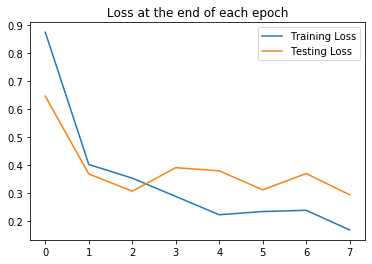

In [8]:
plt.plot(train_losses_all, label='Training Loss')   #Plotting the loss
plt.plot(test_losses_all, label='Testing Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

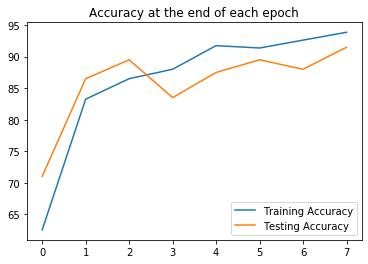

In [9]:
plt.plot(train_correct_all, label='Training Accuracy') #Plotting the accuracy
plt.plot(test_correct_all, label='Testing Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

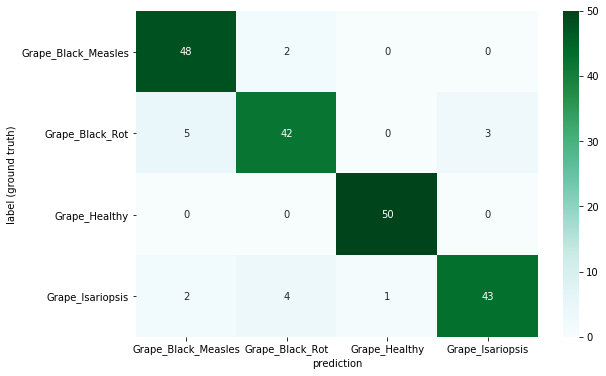

In [10]:
# Create a loader for the entire the test set
t = DataLoader(test_data, batch_size=200, shuffle=False) #batch_size = total test images

with torch.no_grad():
    correct = 0
    for X_test, y_test in t:
        y_val = CNNmodel(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

label -> 0
Prediction is: 0
Actual is: 0
Correct 1


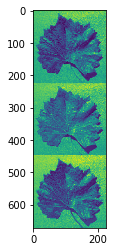

In [11]:
img = test_data[7][0].resize_((1, 3, 224, 224))   #(batch_size,channels,height,width)
correct=0
label = test_data[7][1]
print("label ->", label)
npimg = img.numpy() # img is your tensor
plt.imshow(img.reshape(-1,224))
#plt.imshow(np.transpose(npimg,(1, 2, 0)))
#plt.show()

CNNmodel.eval()
output = CNNmodel(img)
#_, predicted = torch.max(output,1)
predicted = torch.max(output.data, 1)[1] 
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))
##Healthy 0 unhealthy1
correct += (predicted == label).sum()
print("Correct",correct.item())

In [12]:
#My model's parameter
for para in CNNmodel.parameters():
    print (para.numel())

162
6
864
16
5598720
120
9600
80
320
4


In [13]:
AlexNetmodel = models.alexnet(pretrained=True)

In [14]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [16]:
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))

In [17]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [18]:
#Parameters in AlexNet Model
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
4096
4


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [20]:
import time
start_time = time.time()

epochs = 5



train_losses_all = []
test_losses_all = []
train_correct_all = []  #train_accuracy
test_correct_all = []   # test_accuracy

for i in range(epochs):
    train_correct = 0
    test_correct = 0
    total_correct =0
    iterations = 0
    loss_in_iter = 0.0
    
    
    
    # Run the training batches
    for x, (imgTensor, labels) in enumerate(train_loader): 
        
        # Apply the model
        imgTensorOut = AlexNetmodel(imgTensor) 
        loss = loss_fn(imgTensorOut, labels)
        loss_in_iter += loss.item()
 
        # Tally the number of correct predictions
        predicted_index_value = torch.max(imgTensorOut.data, 1)[1]  
        total_correct += (predicted_index_value == labels).sum() 
        train_correct += total_correct
        iterations += 1
      
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    train_losses_all.append(loss_in_iter/iterations)

    train_correct_all.append((100 * total_correct / len(train_data)))
  

    # Run the testing batches
    iterations = 0
    testing_loss = 0.0
    test_correct_in_test = 0
    
    for b, (imgTensor, labels) in enumerate(test_loader):  
           
            # Apply the model
            imgTensorOutTest = AlexNetmodel(imgTensor) 

            # Tally the number of correct predictions
            predicted_index_value = torch.max(imgTensorOutTest.data, 1)[1] 
            test_correct_in_test += (predicted_index_value == labels).sum()  
            iterations += 1

    loss = loss_fn(imgTensorOutTest, labels)
    testing_loss += loss.item()
    
   
    test_losses_all.append(testing_loss/iterations)
    
    test_correct_all.append((100 * test_correct_in_test / len(test_data)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(i+1, epochs, train_losses_all[-1], train_correct_all[-1], 
             test_losses_all[-1], test_correct_all[-1]))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/5, Training Loss: 1.270, Training Accuracy: 81.000, Testing Loss: 0.000, Testing Acc: 88.000
Epoch 2/5, Training Loss: 0.266, Training Accuracy: 93.000, Testing Loss: 0.000, Testing Acc: 96.000
Epoch 3/5, Training Loss: 0.195, Training Accuracy: 95.000, Testing Loss: 0.000, Testing Acc: 91.000
Epoch 4/5, Training Loss: 0.199, Training Accuracy: 95.000, Testing Loss: 0.003, Testing Acc: 95.000
Epoch 5/5, Training Loss: 0.235, Training Accuracy: 94.000, Testing Loss: 0.000, Testing Acc: 93.000

Duration: 492 seconds


In [21]:
print(test_correct_all)
print(f'Test accuracy: {test_correct_all[-1].item()*100/len(test_data):.3f}%')

[tensor(88), tensor(96), tensor(91), tensor(95), tensor(93)]
Test accuracy: 46.500%


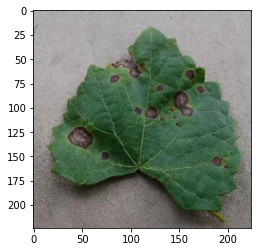

In [22]:
x = 53
im = inv_normalize(test_data[x][0])  #[0] -> image, [1]->label
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [23]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [24]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 Grape_Black_Rot


In [25]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 Grape_Black_Rot
